In [3]:
import pandas as pd
import warnings
import json
import os

os.chdir("/home/antonia/code/Unlocking-Information/")
warnings.filterwarnings("ignore")

folder_name = 'metadata'

In [4]:
rpad_df = pd.read_excel(r'RPAD_data_small.xlsx', engine='openpyxl')
print(rpad_df.shape)
# print(rpad_df.head(5))

(782, 11)


In [5]:
from sdv.metadata import SingleTableMetadata

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=rpad_df)

In [6]:
str_col = ['Sex', 'Management', 'Severity']
int_col = ['Length_of_Stay', 'Alvarado_Score', 'Paedriatic_Appendicitis_Score']
float_col = ['Age', 'BMI', 'Height', 'Weight']

for col in rpad_df:
    if col in int_col:
        # explain no needed to assign dtypes
        metadata.update_column(
        column_name=col,
        sdtype='numerical',
        computer_representation='Int64')
    elif col in float_col:
        #rpad_df[col] = rpad_df[col].astype('float')
        metadata.update_column(
        column_name=col,
        sdtype='numerical',
        computer_representation='Float')
metadata.update_column(
    column_name='ID',
    sdtype='id',
    regex_format='[0-9]{4}')

In [7]:
with open("metadata_rpad_data.json", 'w') as f:
   json.dump(metadata.to_dict(), f)

#with open("metadata_rpad_data.json") as f:
#    metadata_dict = json.load(f)
#
#metadata = SingleTableMetadata.load_from_dict(metadata_dict)

In [8]:
from sdv.single_table import CTGANSynthesizer

model = CTGANSynthesizer(metadata)
model.fit(rpad_df)

time needed for preprocessing: -0.05273151397705078


/home/antonia/anaconda3/envs/pycon_demo/lib/python3.10/site-packages/rdt/transformers/categorical.py:381: UserWarning: The data contains 1 new categories that were not seen in the original data (examples: {nan}). Creating a vector of all 0s. If you want to model new categories, please fit the transformer again with the new data.
  warnings.warn(
/home/antonia/anaconda3/envs/pycon_demo/lib/python3.10/site-packages/rdt/transformers/categorical.py:381: UserWarning: The data contains 1 new categories that were not seen in the original data (examples: {nan}). Creating a vector of all 0s. If you want to model new categories, please fit the transformer again with the new data.
  warnings.warn(
/home/antonia/anaconda3/envs/pycon_demo/lib/python3.10/site-packages/rdt/transformers/categorical.py:381: UserWarning: The data contains 1 new categories that were not seen in the original data (examples: {nan}). Creating a vector of all 0s. If you want to model new categories, please fit the transforme

time needed for training: -15.42037034034729


In [9]:
synth_data = model.sample(num_rows=rpad_df.shape[0])
print(synth_data.shape)
#print(synth_data.head(10))
#synth_data.to_csv('synthetic_rpad.csv', index=False)

(782, 11)


In [10]:
model.save(f"pages/evaluation/{folder_name}/results/rpad_data_model.pkl")
#model = CTGANSynthesizer.load(f"pages/evaluation/{folder_name}/results/rpad_data_model.pkl")

In [11]:
# Diagnostic Report:
from sdmetrics.reports.single_table import DiagnosticReport

dg_report = DiagnosticReport()
dg_report.generate(rpad_df, synth_data, metadata, verbose=True)

dg_report.save(filepath=f"pages/evaluation/{folder_name}/results/diagnostic_report.pkl")

Creating report: 100%|██████████| 4/4 [00:04<00:00,  1.05s/it]


DiagnosticResults:

SUCCESS:
✓ The synthetic data covers over 90% of the numerical ranges present in the real data
✓ The synthetic data covers over 90% of the categories present in the real data
✓ Over 90% of the synthetic rows are not copies of the real data
✓ The synthetic data follows over 90% of the min/max boundaries set by the real data


In [12]:
# Quality Report
from sdv.evaluation.single_table import evaluate_quality

quality_report = evaluate_quality(
    rpad_df,
    synth_data,
    metadata
)

quality_report.save(filepath=f"pages/evaluation/{folder_name}/results/quality_report.pkl")

Creating report: 100%|██████████| 4/4 [00:00<00:00, 25.48it/s]



Overall Quality Score: 78.24%

Properties:
Column Shapes: 81.46%
Column Pair Trends: 75.03%


In [13]:
fig = quality_report.get_visualization('Column Shapes')
fig.show()
fig.write_image(file = f"pages/evaluation/{folder_name}/images/col_shapes.png")

In [14]:
from sdv.evaluation.single_table import get_column_plot

fig = get_column_plot(
    real_data=rpad_df,
    synthetic_data=synth_data,
    column_name='Length_of_Stay',
    metadata=metadata
)
    
fig.show()
fig.write_image(file = f"pages/evaluation/{folder_name}/images/col_plot_len_stay.png")


In [27]:
# plot two variables:
from sdv.evaluation.single_table import get_column_pair_plot

fig_categorical = get_column_pair_plot(
    real_data=rpad_df,
    synthetic_data=synth_data,
    column_names=['Severity', 'Management'],
    metadata=metadata)
    
fig_categorical.show()
fig_categorical.write_image(file = f"pages/evaluation/{folder_name}/images/Severity_Management_pair_plot.png")

fig_numerical = get_column_pair_plot(
    real_data=rpad_df,
    synthetic_data=synth_data,
    column_names=['Age', 'Height'],
    metadata=metadata)
    
fig_numerical.show()
fig_categorical.write_image(file = f"pages/evaluation/{folder_name}/images/Age_Height_pair_plot.png")

In [16]:
# Advanced Metrics: 
# check and delete nan-values as these metrics do not work with nan:
print(rpad_df.isna().sum().sum())
rpad_df.dropna(inplace=True)

print(synth_data.isna().sum().sum())
synth_data.dropna(inplace=True)

169
297


In [17]:
from sdmetrics.single_table import BNLikelihood

BNLikelihood.compute(
    real_data=rpad_df,
    synthetic_data=synth_data,
    metadata=metadata
)

0.14920140807773785

In [18]:
from sdmetrics.single_table import GMLogLikelihood

GMLogLikelihood.compute(
    real_data=rpad_df,
    synthetic_data=synth_data
)

-40.00205512175577

In [19]:
from sdmetrics.single_table import LogisticDetection

LogisticDetection.compute(
    real_data=rpad_df,
    synthetic_data=synth_data,
    metadata=metadata
)

0.0041861941445276996

In [20]:
from sdmetrics.single_table import SVCDetection

SVCDetection.compute(
    real_data=rpad_df ,
    synthetic_data=synth_data,
    metadata=metadata
)

0.002600013771259291

In [21]:
# Add custom constraints:
# check constraints on real data -> check all true!
#def is_valid(data, column_bmi, column_weight, column_height):
#    # replace with your custom logic
#    
#    validity = data['BMI'] == data['weight']/data['height']**2
#    return pd.Series(validity)
rpad_df['valid_check'] = round(rpad_df['BMI'],0) == round(rpad_df['Weight']/(rpad_df['Height']/100)**2,0)
#valid_check = rpad_df['BMI'] == rpad_df['Weight']/(rpad_df['Height']/100)**2

print(rpad_df['valid_check'].sum())
print(rpad_df.shape)



682
(705, 12)


In [22]:
rpad_df.drop(rpad_df[round(rpad_df['BMI'],0) != round(rpad_df['Weight']/(rpad_df['Height']/100)**2,0)].index, inplace=True)
rpad_df.drop(columns=['valid_check'], inplace=True)
print(rpad_df.shape)

(682, 11)


In [23]:
def is_valid(column_names, data):
    # replace with your custom logic
    bmi_column = data[column_names[0]]
    weight_column = data[column_names[1]]
    height_column = data[column_names[2]]
    true_values = round(bmi_column,0) == round(weight_column/round(height_column/100)**2,0)
    false_values = round(bmi_column,0) != round(weight_column/round(height_column/100)**2,0)
    return (true_values) | (false_values)
print(is_valid(["BMI", "Weight", "Height"], rpad_df))

0      True
1      True
2      True
3      True
4      True
       ... 
777    True
778    True
779    True
780    True
781    True
Length: 682, dtype: bool


In [24]:
rpad_df.columns

Index(['ID', 'Age', 'BMI', 'Sex', 'Height', 'Weight', 'Length_of_Stay',
       'Management', 'Severity', 'Alvarado_Score',
       'Paedriatic_Appendicitis_Score'],
      dtype='object')

In [25]:
positive_bmi = {
    'constraint_class': 'Positive',
    'constraint_parameters': {
        'column_name': 'BMI',
        'strict_boundaries': True
    }
}

positive_weight = {
    'constraint_class': 'Positive',
    'constraint_parameters': {
        'column_name': 'Weight',
        'strict_boundaries': True
    }
}

positive_height = {
    'constraint_class': 'Positive',
    'constraint_parameters': {
        'column_name': 'Height',
        'strict_boundaries': True
    }
}

positive_los = {
    'constraint_class': 'Positive',
    'constraint_parameters': {
        'column_name': 'Length_of_Stay',
        'strict_boundaries': True
    }
}

positive_age = {
    'constraint_class': 'Positive',
    'constraint_parameters': {
        'column_name': 'Age',
        'strict_boundaries': False
    }
}

positive_a_score = {
    'constraint_class': 'Positive',
    'constraint_parameters': {
        'column_name': 'Alvarado_Score',
        'strict_boundaries': False
    }
}

positive_pa_score = {
    'constraint_class': 'Positive',
    'constraint_parameters': {
        'column_name': 'Paedriatic_Appendicitis_Score',
        'strict_boundaries': False
    }
}

In [26]:
# load the constraint from the file
model = CTGANSynthesizer(metadata, discriminator_steps=5, epochs = 1000)
model.load_custom_constraint_classes(
    filepath='/home/antonia/code/Unlocking-Information/example_custom_constraint.py',
    class_names=['MyCustomConstraintClass']
)

constraint = {
    'constraint_class': 'MyCustomConstraintClass',
    'constraint_parameters': {
        'column_names': ['BMI', 'Weight', 'Height']
    }
}


InvalidConstraintsError: The provided constraint is invalid:
The constraint 'MyCustomConstraintClass' is not defined in '/home/antonia/code/Unlocking-Information/example_custom_constraint.py'.

In [ ]:

#constraint.keys()
model.add_constraints([constraint, positive_bmi, positive_weight, positive_height, positive_los, positive_age, positive_a_score, positive_pa_score])

In [ ]:
model.fit(rpad_df)
# mit vielen constraints und 500 epochen werden quality score schlechter

<sdv.constraints.tabular.create_custom_constraint_class.<locals>.CustomConstraint object at 0x7f6ba064c190>


In [ ]:
model.save('rpad_custom_c_plus_ep1000_dsteps5.pkl')

In [ ]:
from sdmetrics.single_table import LinearRegression, MLPRegressor
# no nans
#rpad_df.dropna(inplace=True) radio buttons mit options

#rpad_df.drop(columns=['ID'], inplace=True)
#synth_data.dropna(inplace=True)
#synth_data.drop(columns=['ID'], inplace=True)
#
#rpad_df = rpad_df[['Weight', 'Height', 'BMI']]
#synth_data = synth_data[['Weight', 'Height', 'BMI']]
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=rpad_df)

MLPRegressor.compute(
    test_data=rpad_df,
    train_data=rpad_df,
    target='BMI',
    metadata=metadata
)

/home/antonia/anaconda3/envs/pycon_demo/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.



-7.143136310602246

In [ ]:
synth_data

In [ ]:
from sdmetrics.single_table import BinaryAdaBoostClassifier, BinaryDecisionTreeClassifier, BinaryLogisticRegression, BinaryMLPClassifier    

BinaryAdaBoostClassifier.compute(
    test_data=real_data,
    train_data=synthetic_data,
    target='boolean_column_name',
    metadata=metadata
)

#BinaryDecisionTreeClassifier.compute(
#    test_data=real_data,
#    train_data=synthetic_data,
#    target='boolean_column_name',
#    metadata=metadata
#)

In [ ]:
from hotelling.stats import hotelling_dict
#str_col = ['Sex', 'Management', 'Severity']
rpad_df.drop(columns=str_col, inplace=True)
synth_data.drop(columns=str_col, inplace=True)
test_dict = hotelling_dict(rpad_df, y=synth_data, bessel=True)
print(test_dict)

{'t2_stat': 36.180475839317374, 'f_stat': 5.143344269863341, 'p_value': 8.79594023018864e-06, 'pooled_var': array([[ 15.35296095,   6.0975824 ,  45.1335684 ,  41.01492769,
         -0.96276395,  -1.41568461,  -0.65852183],
       [  6.0975824 ,  25.93634587,  41.31765225,  64.04215089,
         -1.40605916,  -1.1472927 ,  -0.68619992],
       [ 45.1335684 ,  41.31765225, 546.13697049, 264.28630769,
        -10.56526017,  -9.30573093,  -6.34054316],
       [ 41.01492769,  64.04215089, 264.28630769, 447.53322306,
         -5.31154054,  -5.85340909,  -6.1147548 ],
       [ -0.96276395,  -1.40605916, -10.56526017,  -5.31154054,
          7.5310535 ,   1.57369577,   1.03860677],
       [ -1.41568461,  -1.1472927 ,  -9.30573093,  -5.85340909,
          1.57369577,   4.51260252,   2.17058857],
       [ -0.65852183,  -0.68619992,  -6.34054316,  -6.1147548 ,
          1.03860677,   2.17058857,   3.71066199]])}


(705, 10)


/home/antonia/anaconda3/envs/pycon_demo/lib/python3.10/site-packages/hotelling/plots.py:88: FutureWarning:

The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.

/home/antonia/anaconda3/envs/pycon_demo/lib/python3.10/site-packages/hotelling/plots.py:90: FutureWarning:

The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.

/home/antonia/anaconda3/envs/pycon_demo/lib/python3.10/site-packages/hotelling/plots.py:90: FutureWarning:

The default value of numeric_only in DataFrame.cov is deprecated. In a future version, it will default to False. Select only valid columns or specify th

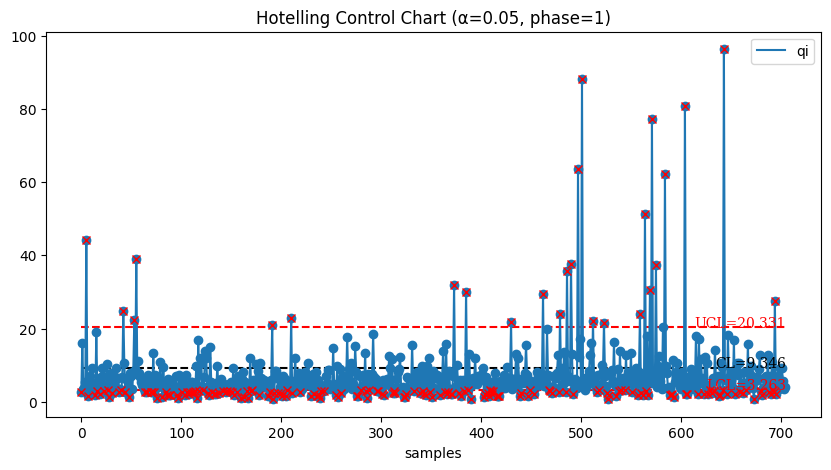

In [ ]:
from hotelling.plots import control_chart, control_stats, univariate_control_chart
rpad_df.dropna(inplace=True)
#rpad_df.drop(columns=['ID'], inplace=True)
print(rpad_df.shape)
ax = control_chart(rpad_df, alpha=0.05, legend_right=True)



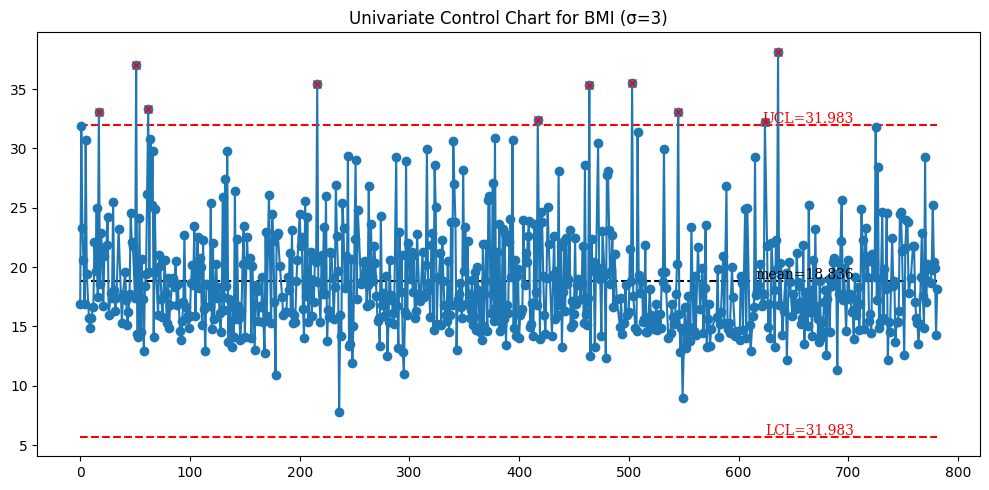

In [ ]:
fig = univariate_control_chart(rpad_df[['BMI']], legend_right=True)

In [ ]:
x_bar, s = control_stats(rpad_df)
x_bar

/home/antonia/anaconda3/envs/pycon_demo/lib/python3.10/site-packages/hotelling/plots.py:88: FutureWarning:

The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.

/home/antonia/anaconda3/envs/pycon_demo/lib/python3.10/site-packages/hotelling/plots.py:90: FutureWarning:

The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.

/home/antonia/anaconda3/envs/pycon_demo/lib/python3.10/site-packages/hotelling/plots.py:90: FutureWarning:

The default value of numeric_only in DataFrame.cov is deprecated. In a future version, it will default to False. Select only valid columns or specify th

Age                               11.284591
BMI                               18.835506
Height                           147.891206
Weight                            43.052071
Length_of_Stay                     4.225532
Alvarado_Score                     5.896454
Paedriatic_Appendicitis_Score      5.229787
dtype: float64

In [ ]:


help(univariate_control_chart)



Help on function univariate_control_chart in module hotelling.plots:

univariate_control_chart(x, var=None, sigma=3, legend_right=False, interactive=False, connected=True, width=10, cusum=False, cusum_only=False, template='none', marker='o', ooc_marker='x', limit=1000, random_state=42, no_display=False)
    univariate_control_chart.
    
    :param x: dask or pandas dataframe, uni or multivariate
    :param var: optional, variable to plot (default to all)
    :param sigma: default to 3 sigma from mean for upper and lower control lines
    :param legend_right: default to 'left', can specify 'right'
    :param interactive: if plotly is available, renders as interactive plot in notebook. False to render image.
    :param connected: defaults to True. Appropriate when time related /consecutive batches, else, should be False
    :param width: how many units wide. defaults to 10, good for notebooks
    :param cusum: use cumulative sum instead of average
    :param cusum_only: don't display va

In [ ]:
synth_data.dropna(inplace=True)
print(synth_data.shape)
synth_data.drop(columns=['ID'], inplace=True)

(523, 11)


/home/antonia/anaconda3/envs/pycon_demo/lib/python3.10/site-packages/hotelling/stats.py:181: FutureWarning:

The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.

/home/antonia/anaconda3/envs/pycon_demo/lib/python3.10/site-packages/hotelling/stats.py:181: FutureWarning:

The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.

/home/antonia/anaconda3/envs/pycon_demo/lib/python3.10/site-packages/hotelling/stats.py:181: FutureWarning:

The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_on

<AxesSubplot:title={'center':'Hotelling Control Chart (α=0.01, phase=2)'}, xlabel='samples'>

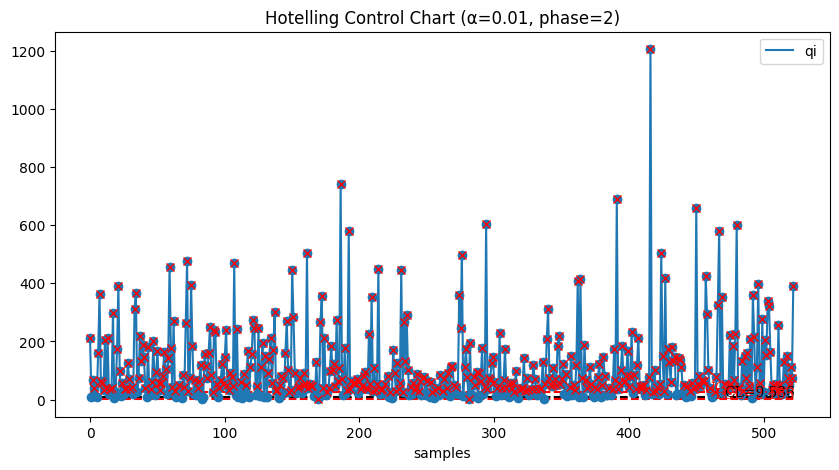

In [ ]:
control_chart(synth_data, alpha=0.01, phase=2, x_bar=x_bar, s=s, legend_right=True)

In [ ]:
# Interpretiere above aussagen: -> wo muss näher reingeschaut werden + warum?
#import json

#with open('my_metadata_file.json', 'w') as f:
#    json.dump(metadata_coltypes, f)


#with open('my_metadata_file.json') as f:
#    metadata_coltypes = json.load(f)

# use my_metadata_dict in the SDMetrics library


# Bis hierhin sind essential steps die super in documentation nachgelesen werden können. -> hier tips und tricks erklären (zum mitcoden wenn möchten)
# danach wie verbesere ich es?

In [ ]:
fig = univariate_control_chart(rpad_df[0:3])

ValueError: Single argument to subplot must be a three-digit integer, not 1111

<Figure size 1000x5500 with 0 Axes>